In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context='paper', palette='muted', font='serif', font_scale=1.2);
from shapely import wkt
import pyodbc
from sqlalchemy.engine import create_engine, URL
from sqlalchemy import inspect
from scipy.stats import norm, sem, ttest_ind
import plotly.express as px
import pingouin as pg
Z = norm()


### Set up database connection

In [2]:
SERVER = 'localhost'
DATABASE = 'AdventureWorks2022'

connection_string = f'DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={SERVER};DATABASE={DATABASE};Trusted_Connection=yes;Encrypt=no'
connection_url = URL.create('mssql+pyodbc', query={'odbc_connect': connection_string})
engine = create_engine(connection_url)

## Human resources


### Data över anställda

In [3]:
# Number of employees by dept.

emp_dept_sql = """ 
SELECT Department
    -- ,Gender
    ,COUNT(Department) EmpCount
FROM HumanResources.Employee A
INNER JOIN HumanResources.vEmployeeDepartment B
    ON A.BusinessEntityID = B.BusinessEntityID
GROUP BY Department
ORDER BY EmpCount DESC """

emp_dept_df = pd.read_sql(emp_dept_sql, engine)

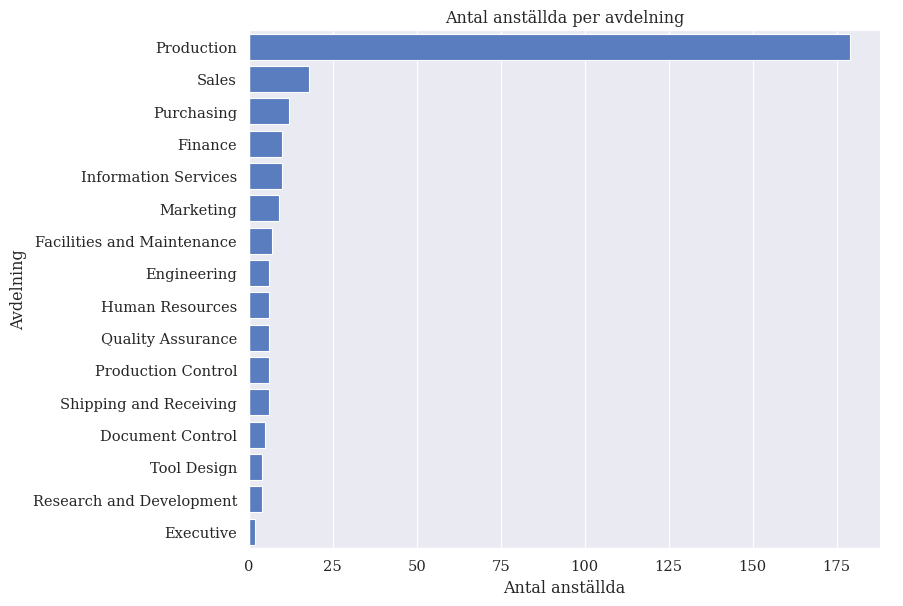

In [4]:
# Plot employees per dept.

fg = sns.catplot(data=emp_dept_df, y='Department', x='EmpCount', kind='bar', height=6, aspect=1.5)
fg.set(title='Antal anställda per avdelning', xlabel='Antal anställda', ylabel='Avdelning')

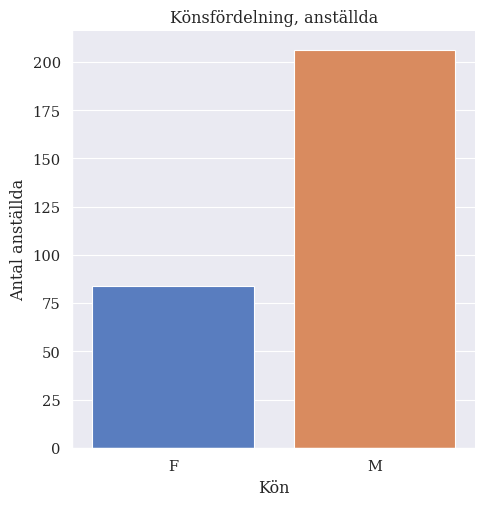

In [5]:
# Employee gender statistics
emp_gender_sql = """ 
SELECT Gender,
    COUNT(Gender) GenderCount
FROM HumanResources.Employee
GROUP BY Gender
"""

emp_gender_df = pd.read_sql(emp_gender_sql, engine)
fg = sns.catplot(data=emp_gender_df, kind='bar', x='Gender', y='GenderCount', hue='Gender')
fg.set(title='Könsfördelning, anställda', xlabel='Kön', ylabel='Antal anställda')

In [6]:
# Query for individual rates with highest rate for each employee.

invidvidual_rates_sql = """ 
SELECT DISTINCT A.BusinessEntityID
    ,Gender
    ,MAX(Rate)
    OVER (  PARTITION BY A.BusinessEntityID
            ORDER BY Rate DESC) Rate
    ,Department
FROM HumanResources.Employee A
INNER JOIN HumanResources.EmployeePayHistory B
    ON A.BusinessEntityID = B.BusinessEntityID
INNER JOIN HumanResources.vEmployeeDepartment C
    ON A.BusinessEntityID = C.BusinessEntityID
"""
invidvidual_rates_df = pd.read_sql(invidvidual_rates_sql, engine)

In [7]:
# Is the pay gap between genders statistically significant?

f_invidvidual_rates_df = invidvidual_rates_df.query('Gender == "F"')
m_invidvidual_rates_df = invidvidual_rates_df.query('Gender == "M"')

f_rate_mean = f_invidvidual_rates_df.Rate.mean()
m_rate_mean = m_invidvidual_rates_df.Rate.mean()
f_rate_var = f_invidvidual_rates_df.Rate.var()
m_rate_var = m_invidvidual_rates_df.Rate.var()
number_of_f_emp = len(f_invidvidual_rates_df)
number_of_m_emp = len (m_invidvidual_rates_df)

# Perform a t-test
pg.ttest(f_invidvidual_rates_df.Rate, m_invidvidual_rates_df.Rate)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.951177,165.679067,two-sided,0.3429,"[-1.58, 4.51]",0.119171,0.217,0.150597


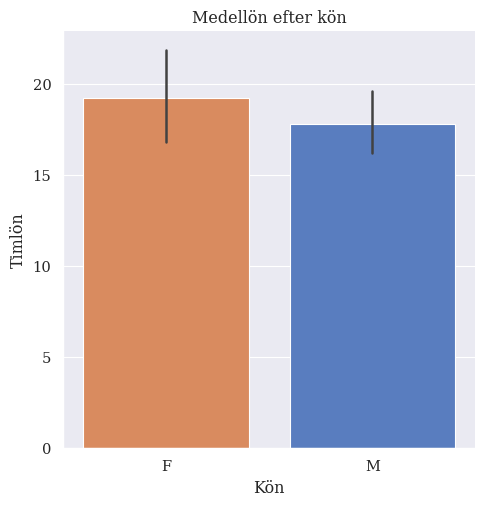

In [8]:
# Plot mean rate by gender

fg = sns.catplot(data=invidvidual_rates_df, x='Gender', y='Rate', hue='Gender', kind='bar', order=['F', 'M'])
fg.set(title='Medellön efter kön', xlabel='Kön', ylabel='Timlön');


### Sjuktimmar och semester

In [9]:
# 
sick_leave_and_vacation_hours_sql = """
select A.BusinessEntityID
    ,C.Department
    ,B.FirstName
    ,B.LastName
    ,A.Gender
    ,A.SickLeaveHours
    ,A.VacationHours
    ,CUME_DIST()
        OVER(
            PARTITION BY C.Department
            ORDER BY A.SickLeaveHours
        ) AS cum_dist_slh
from HumanResources.Employee A
inner join Person.Person B
    on A.BusinessEntityID = B.BusinessEntityID
inner join HumanResources.vEmployeeDepartment C
    on A.BusinessEntityID = C.BusinessEntityID
    """

In [10]:
sick_leave_and_vacation_hours_df = pd.read_sql(sick_leave_and_vacation_hours_sql, engine)

In [41]:
# Plot sick leave hours by dept. and gender
#sns.catplot(data=sick_leave_and_vacation_hours_df, y='SickLeaveHours', x='Gender', hue='Gender', col='Department', kind='box', col_wrap=4, sharey=True)

### Sjuktimmar

In [12]:
# Sjuktimmar per avdelning
sickleave_sql = """ 
SELECT B.Department
    ,A.BusinessEntityID
    ,A.SickLeaveHours
FROM HumanResources.Employee A
INNER JOIN HumanResources.vEmployeeDepartment B
    ON A.BusinessEntityID = B.BusinessEntityID
ORDER BY SickLeaveHours
 """

sickleave_df = pd.read_sql(sickleave_sql, engine)

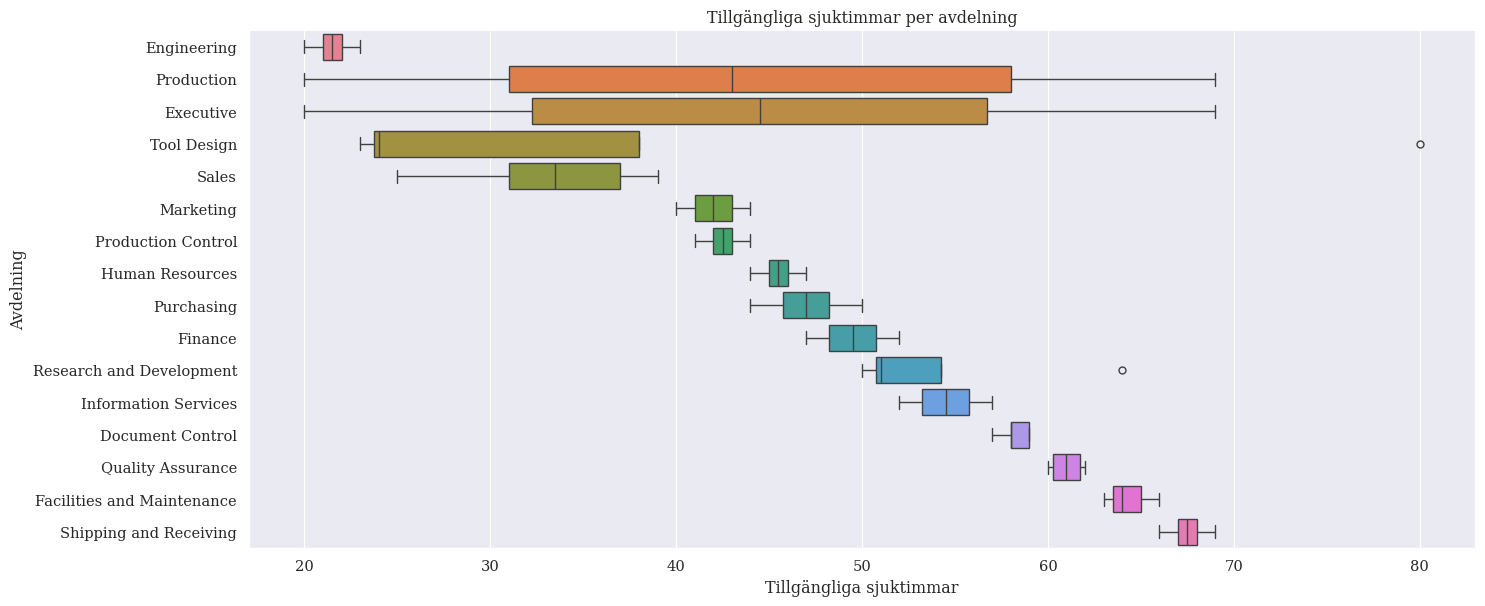

In [13]:
# Plot sick leave hours per dept.

fg = sns.catplot(data=sickleave_df, y='Department', x='SickLeaveHours', hue='Department', kind='box', height=6, aspect=2.5)
fg.set(title='Tillgängliga sjuktimmar per avdelning', xlabel='Tillgängliga sjuktimmar', ylabel='Avdelning')

In [14]:
# How long have the employees been working at AdventureWorks?
# Check for shifts between departments? 

months_worked_sql = """ 
WITH MonthsWorked_CTE AS
(
SELECT DATEDIFF(MONTH, HireDate, '2014-06-30') MonthsWorked
    ,B.Department
FROM HumanResources.Employee A
INNER JOIN HumanResources.vEmployeeDepartment B
    ON A.BusinessEntityID = B.BusinessEntityID
)
SELECT *
    ,AVG(MonthsWorked) OVER (PARTITION BY Department) AvgDeptEmpTime
FROM MonthsWorked_CTE
ORDER BY AvgDeptEmpTime DESC """

months_worked_df = pd.read_sql(months_worked_sql, engine)

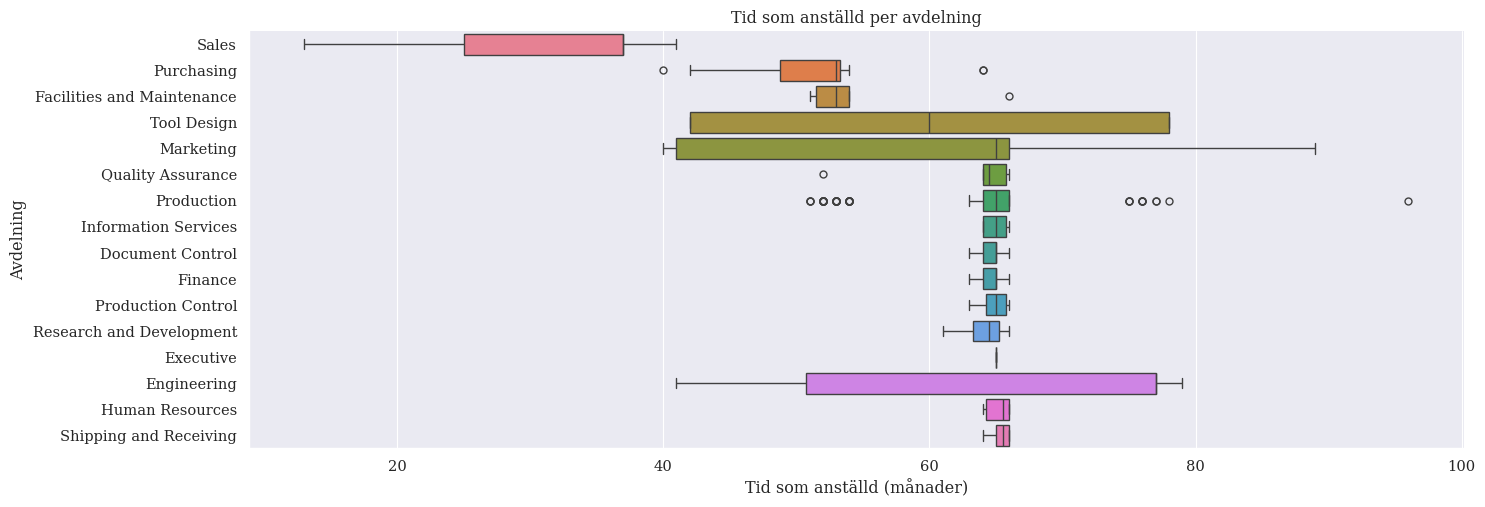

In [15]:
# Plot employment times

fg = sns.catplot(data=months_worked_df.sort_values('AvgDeptEmpTime'), y='Department', x='MonthsWorked', hue='Department', kind='box', aspect=3)
fg.set(title='Tid som anställd per avdelning', xlabel='Tid som anställd (månader)', ylabel='Avdelning')

In [16]:
# Konfidensintervall för antal semestertimmar per avdelning
vacation_ci_sql = """ 
WITH VacationHours_CTE AS
(
SELECT *
FROM HumanResources.vVacationHours
), VacationHoursWithTValues_CTE AS
(
SELECT *
    ,(CASE 
        WHEN VacationHours_CTE.NumberofEmployees < 30 THEN
            (SELECT p05 
            FROM dbo.CriticalTValues T
            WHERE T.Df = VacationHours_CTE.NumberofEmployees-1)
        ELSE 
            (SELECT 1.96)
        END) [T-value]
FROM VacationHours_CTE
)
SELECT Department
    ,AvgVacationHours
    ,[AvgVacationHours]-[T-value]*StErrVacationHours LowInterval
    ,[AvgVacationHours]+[T-value]*StErrVacationHours HighInterval
FROM VacationHoursWithTValues_CTE
 """

vacation_ci_df = pd.read_sql(vacation_ci_sql, engine)
vacation_ci_df.sort_values('LowInterval', inplace=True)
vacation_ci_df.reset_index(inplace=True)

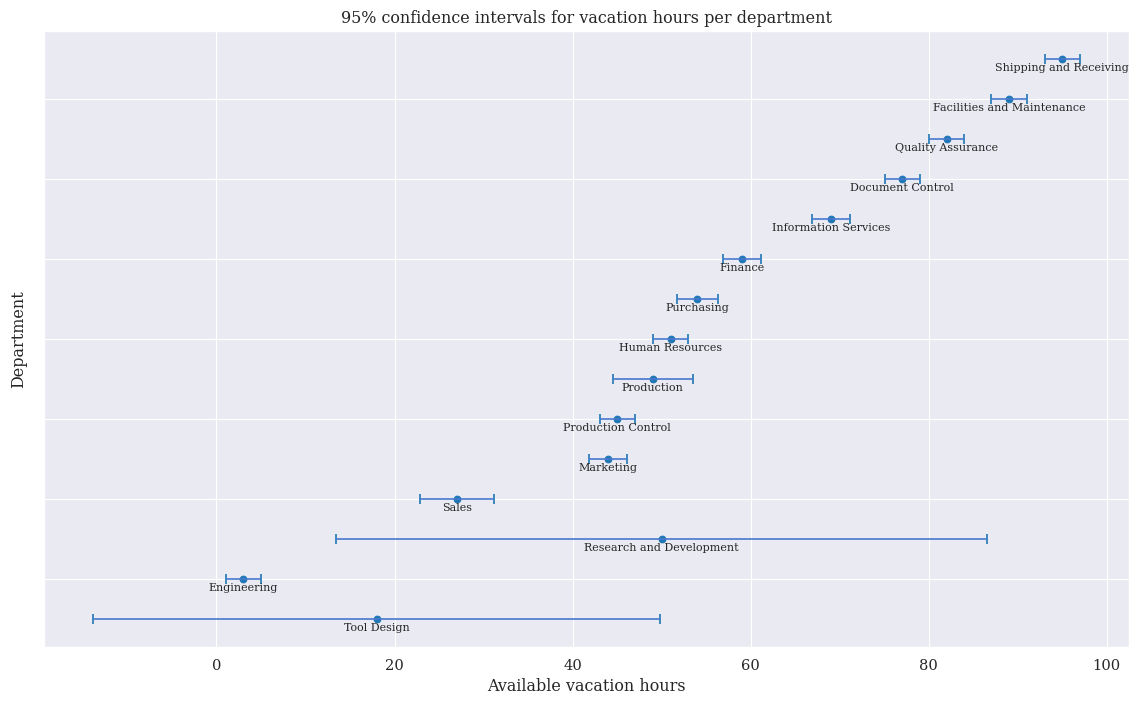

In [17]:
fig, ax = plt.subplots(figsize=(14, 8))
for i, row in vacation_ci_df.iterrows():
    # Filter out Executives
    if row.Department != 'Executive':
        ax.hlines(i, row.LowInterval, row.HighInterval, label=row.Department)
        ax.scatter(row.AvgVacationHours, i, c='tab:blue')
        ax.scatter(row.LowInterval, i, marker='|', s=50, c='tab:blue')
        ax.scatter(row.HighInterval, i, marker='|', s=50, c='tab:blue')
        ax.annotate(row.Department, (row.AvgVacationHours, i-.3), ha='center', fontsize=8)
ax.set(title='95% confidence intervals for vacation hours per department', xlabel='Available vacation hours', ylabel='Department', yticklabels=[]);
# Färg efter antal anställda?

### Lönestatistik

In [18]:
# Pay rate by dept. and gender

employee_payrate_sql = """ 
SELECT DISTINCT A.BusinessEntityID
    ,A.Gender
    ,A.JobTitle
    ,C.Department
    ,MAX(D.Rate)
        OVER(   PARTITION BY   A.BusinessEntityID
                ORDER BY       D.Rate DESC
            ) EmployeeRate
    ,AVG(D.Rate)
        OVER (PARTITION BY C.Department) DeptAvgRate
FROM HumanResources.Employee A
INNER JOIN HumanResources.vEmployeeDepartment C
    ON A.BusinessEntityID = C.BusinessEntityID
INNER JOIN HumanResources.EmployeePayHistory D
    ON A.BusinessEntityID = D.BusinessEntityID
-- WHERE Department NOT LIKE 'Executive'
-- WHERE OrganizationLevel > 1
GROUP BY A.BusinessEntityID, Department, Rate, Gender, A.JobTitle
"""

In [19]:
employee_payrate_df = pd.read_sql(employee_payrate_sql, engine)

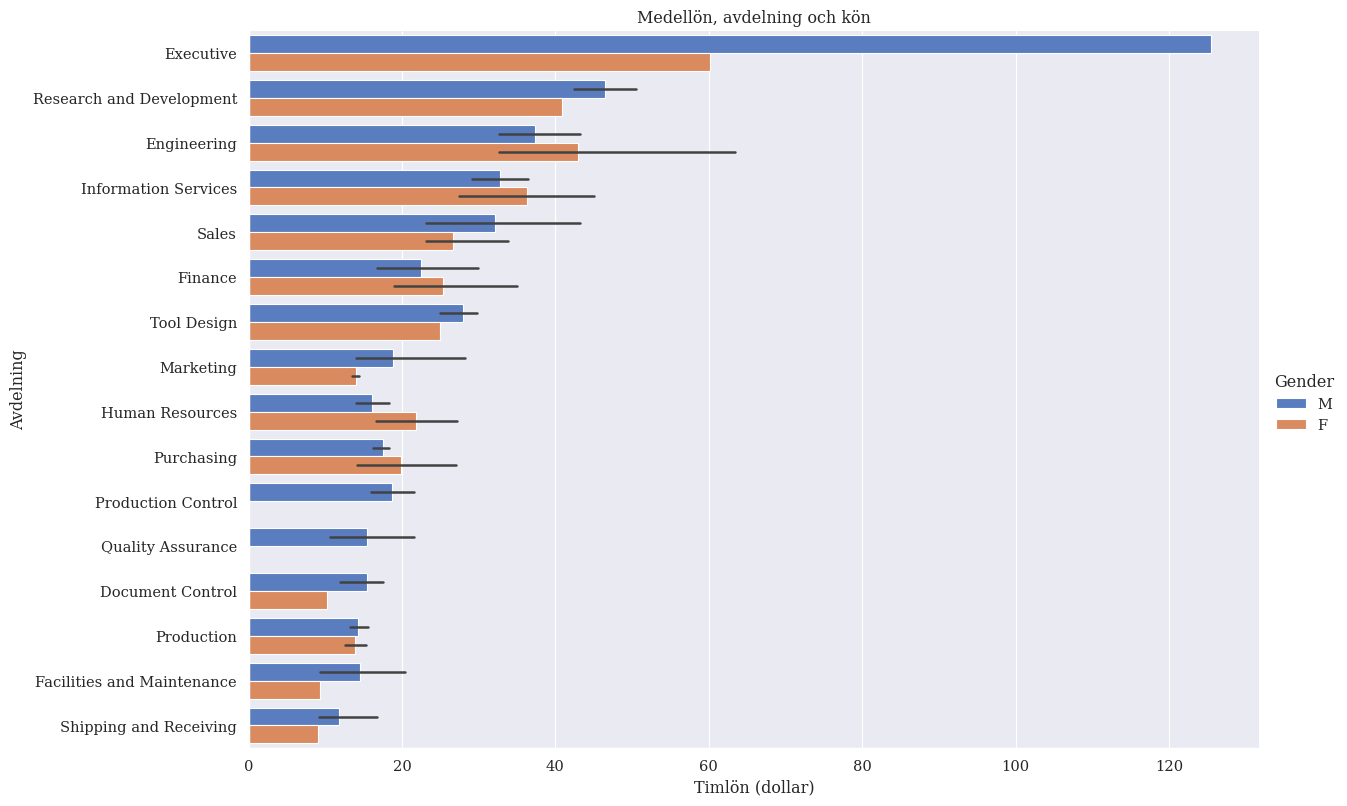

In [20]:
# Plot mean rate per dept.

fg = sns.catplot(data=employee_payrate_df.sort_values('DeptAvgRate', ascending=False), y='Department', x='EmployeeRate', hue='Gender', kind='bar', height=8, aspect=1.618)

fg.set(title='Medellön, avdelning och kön', xlabel='Timlön (dollar)', ylabel='Avdelning')

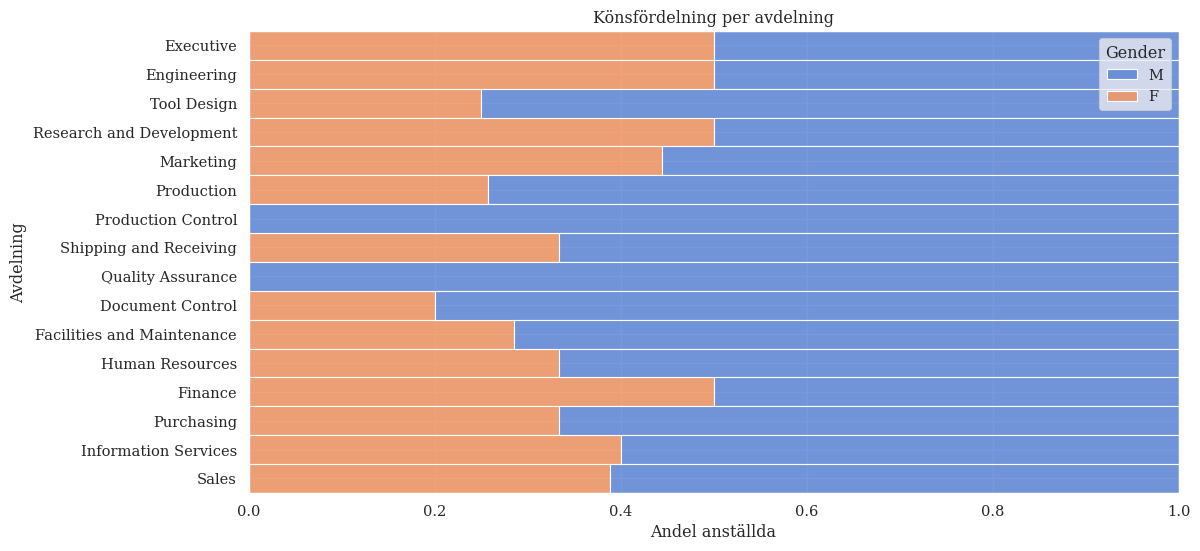

In [21]:
# Plot gender proportions per dept.

fig, ax = plt.subplots(figsize=(12, 6)) 

sns.histplot(data=employee_payrate_df, stat='proportion', element='bars', hue='Gender', y='Department', multiple='fill', ax=ax)

ax.set(title='Könsfördelning per avdelning', xlabel='Andel anställda', ylabel='Avdelning');

Text(0.5, 39, 'Avdelningens medellön')

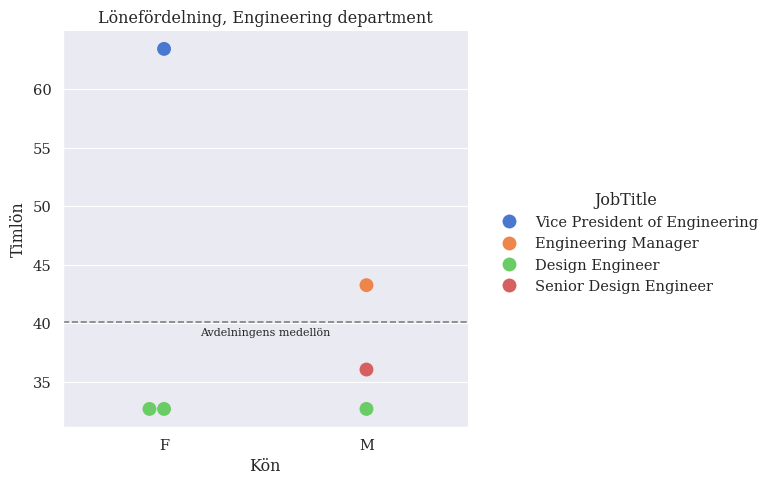

In [22]:
# Plot a swarm plot over engineering dept. rates

fg = sns.catplot(employee_payrate_df.query('Department == "Engineering"'), x='Gender', y='EmployeeRate', hue='JobTitle', kind='swarm', palette='muted', size=10)
fg.set(title='Lönefördelning, Engineering department', xlabel='Kön', ylabel='Timlön')
fg.refline(y=employee_payrate_df.query('Department == "Engineering"').DeptAvgRate.mean())
plt.annotate('Avdelningens medellön', xy=(.5, 39), fontsize=8, ha='center')

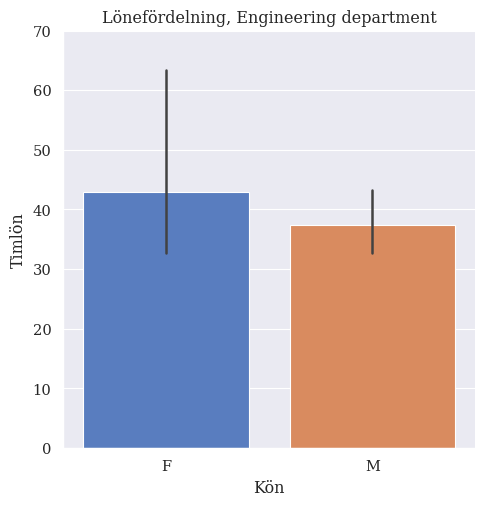

In [23]:
# Plot mean rates per gender for engineering dept.

fg = sns.catplot(employee_payrate_df.query('Department == "Engineering"'), x='Gender', y='EmployeeRate', hue='Gender', kind='bar', palette='muted', order=['F', 'M'], hue_order=['F', 'M'])
fg.set(title='Lönefördelning, Engineering department', xlabel='Kön', ylabel='Timlön', ylim=[0, 70])

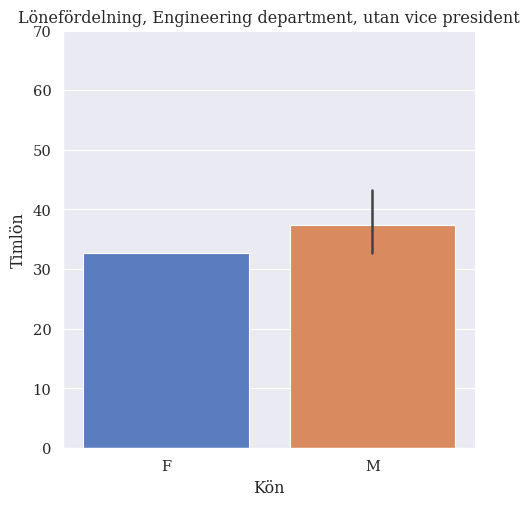

In [24]:
# Plot mean rates per gender for engineering dept. excluding VP

fg = sns.catplot(employee_payrate_df.query('Department == "Engineering" and EmployeeRate < 50'), x='Gender', y='EmployeeRate', hue='Gender', kind='bar', palette='muted', order=['F', 'M'], hue_order=['F', 'M'])
fg.set(title='Lönefördelning, Engineering department, utan vice president', xlabel='Kön', ylabel='Timlön', ylim=[0, 70])

## Ekonomi

### Försäljning och inköp

In [31]:
# 2013 Q1-Q2 and Q3-Q4
sales_2013_sql = """ 
SELECT SUM(SubTotal) Total
    ,'Q1-Q2' Period
FROM Sales.SalesOrderHeader
WHERE YEAR(OrderDate) = '2013' AND MONTH(OrderDate) <= 6
UNION
SELECT SUM(SubTotal) Total
    ,'Q3-Q4' Period
FROM Sales.SalesOrderHeader
WHERE YEAR(OrderDate) = '2013' AND MONTH(OrderDate) > 6 """

sales_2013_df = pd.read_sql(sales_2013_sql, engine)
sales_2013_df.set_index('Period', inplace=True)

Text(0, 0.5, 'Total försäljning')

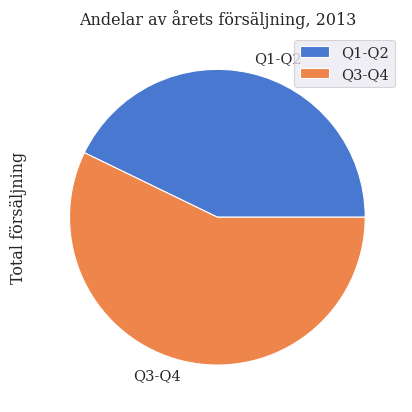

In [32]:
# Plot sales share for first and second half of 2013
ax = sales_2013_df.plot(kind='pie', y='Total', title='Andelar av årets försäljning, 2013')
ax.set_ylabel('Total försäljning')

In [33]:
# Sales and purchases per year and month
sales_and_purchases_sql = """ 
SELECT YEAR(OrderDate) [Year]
    ,MONTH(OrderDate) [Month]
    ,'Försäljning' TransactionType
    ,SUM(SubTotal) SubTotalSum
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), Month(OrderDate)
UNION

SELECT YEAR(OrderDate) [Year]
    ,MONTH(OrderDate) [Month]
    ,'Inköp' TransactionType
    ,SUM(SubTotal) SubTotalSum
FROM Purchasing.PurchaseOrderHeader 
GROUP BY YEAR(OrderDate), Month(OrderDate)
"""

sales_and_purchases_df = pd.read_sql(sales_and_purchases_sql, engine)
# Add Date column
sales_and_purchases_df['Date'] = pd.to_datetime(sales_and_purchases_df[['Year', 'Month']].assign(DAY=28))

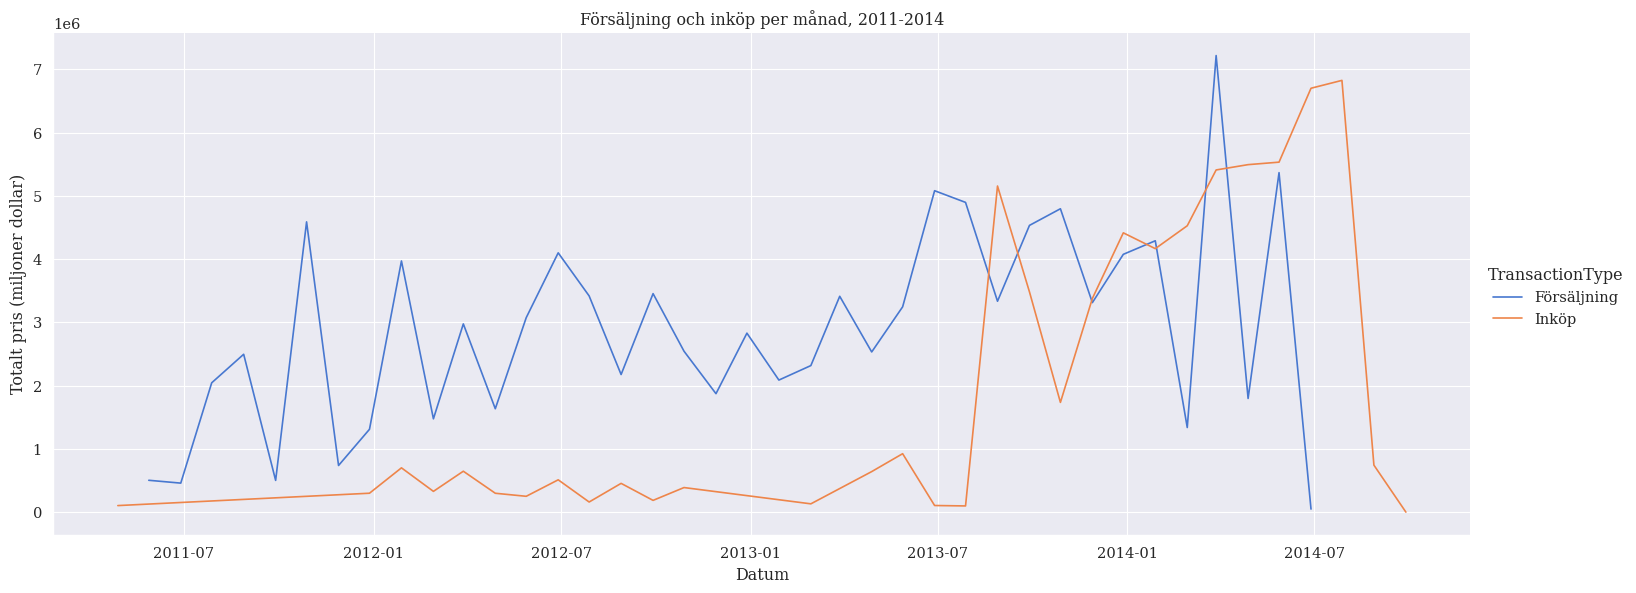

In [34]:
fg = sns.relplot(data=sales_and_purchases_df, x='Date', y='SubTotalSum', hue='TransactionType', kind='line', aspect=2.5, height=6)
fg.set(title='Försäljning och inköp per månad, 2011-2014', xlabel='Datum', ylabel='Totalt pris (miljoner dollar)')

In [35]:
# Estimate sales for last half of 2014

predicted_sales_2014_sql = """ 
DECLARE @Tvalue DECIMAL(5, 2);
SET @Tvalue = 2.776;
WITH SalesPerMonth_CTE AS (

    SELECT MONTH(OrderDate) Month
        -- ,COUNT(*) NumberOfSales
        ,COUNT(*)/3 AvgNumberOfSales -- 2011-2013
        -- ,CAST(SUM(SubTotal) AS DECIMAL(10, 2)) TotalSales
        ,CAST(AVG(SubTotal) AS DECIMAL(10,2)) AvgSalesAmount
        -- ,CAST(STDEV(SubTotal) AS DECIMAL(10, 2)) StdSales
        ,CAST(STDEV(SubTotal)/SQRT(COUNT(*)/3) AS DECIMAL(10, 2)) StdErrSalesAmount
    FROM sales.SalesOrderHeader A
    WHERE MONTH(OrderDate) >= 7
    GROUP BY MONTH(OrderDate)
    -- ORDER BY [Month]
)
SELECT Month
    ,AvgNumberOfSales * (AvgSalesAmount-@Tvalue*StdErrSalesAmount) IntervalLow
    ,AvgNumberOfSales * (AvgSalesAmount+@Tvalue*StdErrSalesAmount) IntervalHigh
FROM SalesPerMonth_CTE
ORDER BY [Month] """

predicted_sales_2014_df = pd.read_sql(predicted_sales_2014_sql, engine)
# Add Date column
predicted_sales_2014_df['Date'] = pd.to_datetime(predicted_sales_2014_df[['Month']].assign(YEAR=2014, DAY=28))

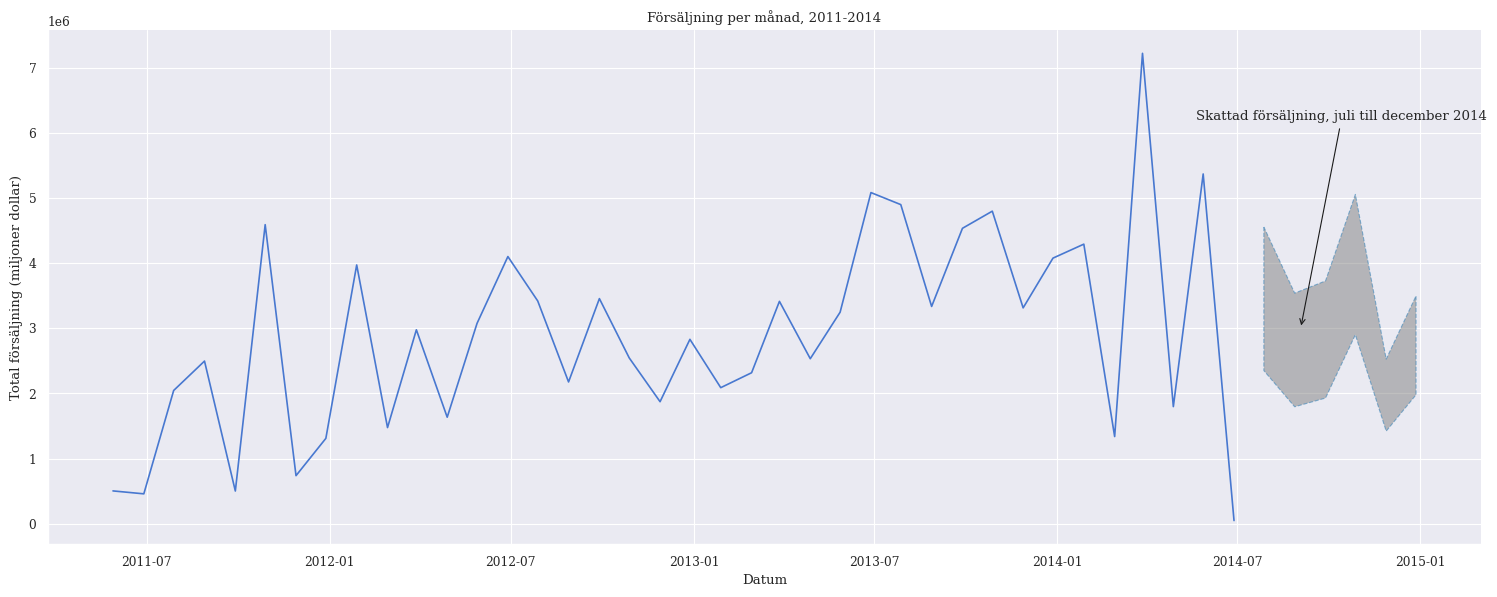

In [43]:
# Plot sales and add estimated sales

sns.set_context('paper')
fg = sns.relplot(data=sales_and_purchases_df.query('TransactionType == "Försäljning"'), x='Date', y='SubTotalSum', kind='line', height=6, aspect=2.5)
plt.fill_between(predicted_sales_2014_df.Date, predicted_sales_2014_df.IntervalLow, predicted_sales_2014_df.IntervalHigh, alpha=.5, facecolor='gray', edgecolor='tab:blue', linestyle='dashed')
fg.set(title='Försäljning per månad, 2011-2014', xlabel='Datum', ylabel='Total försäljning (miljoner dollar)')
plt.annotate('Skattad försäljning, juli till december 2014', (pd.to_datetime('20140903', format='%Y%m%d'), 3e6), xytext=(-75, 150), textcoords='offset points', arrowprops={'arrowstyle': '->', 'color': 'k'});

In [37]:
# Transactions monthly
transaction_history_sql = """ 
SELECT A.ProductID
    ,A.TransactionDate
    ,A.TransactionType
    ,A.Quantity
    ,A.ActualCost
    -- ,A.Quantity*A.ActualCost TotalCost
    ,(CASE   WHEN A.TransactionType = 'S' 
                THEN
                    A.Quantity * B.ListPrice
            ELSE 
                    A.Quantity * B.StandardCost
    END) TotalCost
FROM Production.TransactionHistory A
INNER JOIN Production.Product B
    ON A.ProductID = B.ProductID
WHERE A.TransactionType = 'S' OR A.TransactionType = 'P'
-- GROUP BY A.ProductID, Name, TransactionDate, TransactionType, Quantity, ActualCost
ORDER BY TotalCost DESC """
transaction_history_df = pd.read_sql(transaction_history_sql, engine)

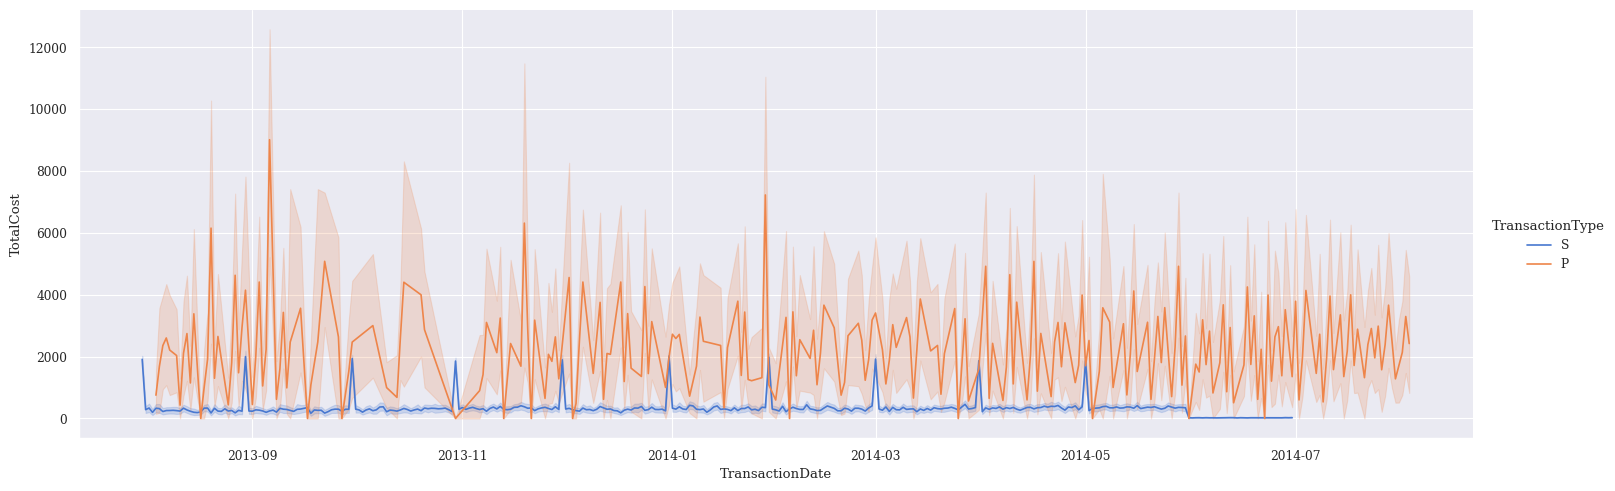

In [38]:
sns.relplot(data=transaction_history_df, x='TransactionDate', y='TotalCost', hue='TransactionType', kind='line', aspect=3)

Kanske imorgon att jag utgår från produkter och därifrån ser hur många som köpts in av dem för att få ett avslut på försäljning och inköps-delen.

## GIS

In [39]:
# Query for locations of store contacts and invidvidual customers
sql = '''
SELECT 
    A.FirstName
    ,A.LastName
    ,CASE WHEN A.PersonType = 'SC' THEN 'Store contact'
        ELSE 'Individual customer'
    END Type
    ,B.City
    ,B.SpatialLocation.STAsText() Location
FROM Person.Person A
INNER JOIN Person.Address B
    ON A.BusinessEntityID = B.AddressID
WHERE SpatialLocation.STAsText() NOT LIKE '%(0 0)%'
    AND (A.PersonType = 'IN' OR A.PersonType = 'SC')
'''

location_df = pd.read_sql(sql, engine)
location_df['Location'] = location_df.Location.apply(wkt.loads)
gdf = gpd.GeoDataFrame(location_df)
gdf = gdf.set_geometry('Location')

gdf = gdf.set_crs(epsg=3857)

In [40]:
fig = px.scatter_mapbox(gdf, lat=gdf.geometry.y, lon=gdf.geometry.x, zoom=2, opacity=.75, color='Type', title='Store contact and individual customer locations')
fig.update_layout(mapbox_style='carto-positron', height=750)
fig.show()